In [3]:
# Imports 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

%matplotlib inline


In [4]:
# Data loading and preperation 

test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

C:\Users\Logan\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

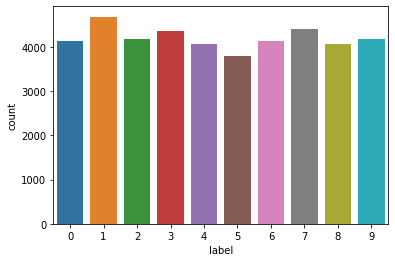

In [8]:
y_train = train['label']

x_train = train.drop('label', axis=1)

sns.countplot(y_train)

y_train.value_counts()

In [10]:
# Data Cleaning
x_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [11]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [12]:
# Normalization

x_train = x_train / 255
test = test / 255 

In [14]:
# Reshape
# These 'images' are held in the dataframe with the shape 784,1 so to correctly load the images we need to reshape them into 
# 28x28 matrices. The 4th value in the reshape represents the number of 'channels' where 1 means black and white. 3 channels 
# would be RGB. 

x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [15]:
# Label Encoding 
y_train = to_categorical(y_train, num_classes=10)

In [31]:
# Split the data 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Now that we have completed the data preperation we will now build the CNN Model. We will be using a Keras Sequential Model. The first layer will have 32 filters and will use the variable Kernal_size which sections the image into evenly spaced parts, in this case (5,5 pixels). Each filter will look at a single kernal and will pass on the data to the next layer. we will have two of these layers  before moving on to 64 filter layers. 

Between these two sets of layers we will have a MaxPool2D layer which is called a pooling layer. This layer acts as a downsampling filter by looking at the two neighboring pixels and selecting the largest value. The size of the layer represents how large of an area in the image we want to 'search' in for the largest value. 

Dropout is a regularization method where a proportion of nodes in the layer are randomly ignored and have their weights set to 0 for the training sample. This randomly drops a proportion of the network and forces the learn the features in a new way. This technique reduces overfitting and improves generalization

In [19]:
Model = Sequential()

Model.add(Conv2D(filters =32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28,28,1)))
Model.add(Conv2D(filters =32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28,28,1)))

Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.25))

# Now we repeat with more filters

Model.add(Conv2D(filters =64, kernel_size=(3,3), padding='same', activation='relu', ))
Model.add(Conv2D(filters =64, kernel_size=(3,3), padding='same', activation='relu', ))

Model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
Model.add(Dropout(0.25)) 

# To finish the model we use a flatten layer to convert the data into a single 1D vector. This step is needed to make full use 
# of the final fully connected layer. The last layer in the model has 10 nodes for each of the classification options and uses
# softmax to return a distribution of probability for each class 

Model.add(Flatten())
Model.add(Dense(256, activation='relu'))
Model.add(Dropout(0.5))
Model.add(Dense(10, activation='softmax'))

Now that we have set up the model we need to set up a score function, a loss function and a optimization algorithm. 

To measure the success of our model we use something called a loss function. This is the error rate between the observed labels and the predicted ones. We use a specific form for categorical classifications with greater than 2 classes called Categorical crossentropy. 

The optimizer is the most important aspect of this model. It will iteratively improce our parameters in order to minimize the loss. The optimizer I will be using is called RMSprop which adjusts the Adagrad method to reduce the learning rate. Another example of a good optimizer is the Stochastic Gradient Descent optimizer but that one is much slower. 

To be able to return a prediction we need to be able to evaluate our models predictions. We will evaluate on the metric 'accuracy' since we care about how accurate each prediction is.

In [21]:
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [ ]:
# Now we can compile the model!
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [27]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 30
batch_size = 86



In [33]:
Model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val), verbose = 2)

Epoch 1/30
313/313 - 32s - loss: 0.1048 - accuracy: 0.9691 - val_loss: 0.0654 - val_accuracy: 0.9792 - 32s/epoch - 103ms/step
Epoch 2/30
313/313 - 33s - loss: 0.0723 - accuracy: 0.9790 - val_loss: 0.0444 - val_accuracy: 0.9850 - 33s/epoch - 104ms/step
Epoch 3/30
313/313 - 33s - loss: 0.0559 - accuracy: 0.9827 - val_loss: 0.0491 - val_accuracy: 0.9851 - 33s/epoch - 106ms/step
Epoch 4/30
313/313 - 36s - loss: 0.0500 - accuracy: 0.9850 - val_loss: 0.0436 - val_accuracy: 0.9876 - 36s/epoch - 114ms/step
Epoch 5/30
313/313 - 35s - loss: 0.0410 - accuracy: 0.9874 - val_loss: 0.0433 - val_accuracy: 0.9878 - 35s/epoch - 110ms/step
Epoch 6/30
313/313 - 33s - loss: 0.0390 - accuracy: 0.9887 - val_loss: 0.0400 - val_accuracy: 0.9881 - 33s/epoch - 105ms/step
Epoch 7/30
313/313 - 32s - loss: 0.0341 - accuracy: 0.9900 - val_loss: 0.0392 - val_accuracy: 0.9875 - 32s/epoch - 103ms/step
Epoch 8/30
313/313 - 32s - loss: 0.0327 - accuracy: 0.9899 - val_loss: 0.0360 - val_accuracy: 0.9891 - 32s/epoch - 103

In [34]:
# predict results
results = Model.predict(test)

# select the index with the maximum probability
results = np.argmax(results, axis = 1)

results = pd.Series(results, name="Label")

875/875 [==============================] - 6s 6ms/step


In [35]:
# create a submission
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"), results], axis = 1)

submission.to_csv("cnn_mnist.csv",index=False)